## **Koloryzacja zdjęć**

### Preprocessing

**Krok 1:** Podłączenie dysku google, w celu załadowania datasetu w postaci zip

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

**Krok 2:** Rozpakowanie datasetu do katalogu /content

In [2]:
# !unzip /content/drive/MyDrive/archive.zip -d /content

**Krok 3:** Importy wykorzystywane w projekcie

In [2]:
# Import required libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sklearn

# Import necessary modules
from sklearn.metrics import mean_squared_error
from math import sqrt

# Keras specific
import keras
from keras.models import Sequential

# Other
from os import listdir
from matplotlib import image
import PIL

# Scaling
import scipy.ndimage

# Pickle
import pickle

# Lab color
from skimage.color import rgb2lab, lab2rgb

**Krok 4:** Metoda ładująca dataset ze zdjęciami.
*   Limit zdjęć: 2500 ze względów pamięciowych
*   Zdjęcia skalowane wg parametru *scaling*
*   Zwraca tablicę numpy ze zdjęciami
*   Struktura zwracanej tablicy numpy w parametrze shape


In [5]:
def load_images(path, shape, scaling=1):
    # load all images in a directory
    lst = list()
    for i, filename in enumerate(listdir(path)):
      if i < 2500:
        # load image
        img_data = image.imread(path + '/' + filename)
        img_data = scipy.ndimage.zoom(img_data, (scaling, scaling, 1), order=0)
        # store loaded image
        lst.append(img_data)
    return np.expand_dims(lst, -1).reshape(shape)

**Krok 5:** Załadowanie 2500 zdjęć oraz przeskalowanie ich do rozmiaru 200x200 z 3 kanałami, czyli przeskalowanie do 0.5 (Rozdzielczość oryginalnie wyczytanych zdjęć 400x400)

In [5]:
train_black_np = load_images('/content/data/train_black', (2500, 200, 200, 3), 0.5)
train_color_np = load_images('/content/data/train_color', (2500, 200, 200, 3), 0.5)

print(train_black_np.shape)
print(train_color_np.shape)

(2500, 200, 200, 3)
(2500, 200, 200, 3)


**Krok 6:** Normalizacja datasetu

In [6]:
train_black_np = train_black_np / 255
train_color_np = train_color_np / 255

**Krok 7:** Przykładowy obraz przed zamianą na skalę kolorów LAB

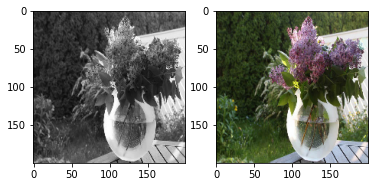

In [7]:
# Przed zamianą i rozkładem na kolory LAB:

f, axarr = plt.subplots(1, 2)
axarr[0].imshow(train_black_np[0])
axarr[1].imshow(train_color_np[0])
plt.show()

**Krok 8:** Zamiana kanałów kolorów z RGB do LAB oraz rozdzielenie ich na osobne datasety.
*   Wykorzystanie zapisu kolorów w modelu LAB daje lepsze efekty niż w RGB
*   Zdjęcie w postaci LAB posiada 3 kanały, jednak jeden z nich już znamy na podstawie wejściowego dla sieci datasetu. Mianowicie jest to szarość obrazka, która jest tym samym co *lightness* w modelu kolorów LAB, zatem 1 z 3 kanałów wyjściowych mamy zdefiniowany. Pozostałe 2 kanały LAB będziemy przewidywać. W przypadku posługiwania się modelem RGB musieli byśmy przewidywać wszystkie 3 kanały.
*   W celu uniknięcia sytuacji, w której proces nauczania dla jednego kanału ma negatywny wpływ na proces nauczania dla drugiego kanału oraz ze względu na możliwość równoległego i niezależnego nauczania przewidywania wartości poszczególnych kanałów, zostają one rodzielone i nauczane osobno, stąd wartości train_color_1_np oraz train_color_2_np



In [8]:
X = list()
Y = list()
Z = list()
for i in range(2500):
  lab_img_black = rgb2lab(train_black_np[i])
  lab_img = rgb2lab(train_color_np[i])
  X.append(lab_img_black[:,:,0])
  Y.append(lab_img[:,:,1])
  Z.append(lab_img[:,:,2])
train_black_np = np.array(X)
train_color_1_np = np.array(Y)
train_color_2_np = np.array(Z)

train_black_np = train_black_np.reshape(train_black_np.shape+(1,))
train_color_1_np = train_color_1_np.reshape(train_color_1_np.shape+(1,))
train_color_2_np = train_color_2_np.reshape(train_color_2_np.shape+(1,))

del X
del Y
del Z
del train_color_np

print(train_black_np.shape)
print(train_color_1_np.shape)
print(train_color_2_np.shape)

(2500, 200, 200, 1)
(2500, 200, 200, 1)
(2500, 200, 200, 1)


**Krok 9:** Poniższy przykład prezentuje sposób złożenia kanału *lightness* oraz obu kanałów koloru w obrazek. Jako wynik ponownie otrzymujemy grafikę z kroku 7.

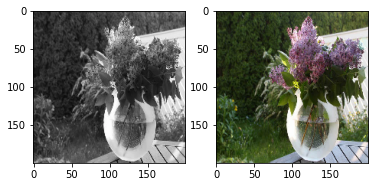

In [9]:
# Po zamianie i rozkładzie na kolory LAB, po ponownym złożeniu:

img_black_np = np.zeros((200, 200, 3))
img_black_np[:,:,0] = train_black_np[0][:,:,0]
img_black = lab2rgb(img_black_np)

img_color_np = np.zeros((200, 200, 3))
img_color_np[:,:,0] = train_black_np[0][:,:,0]
img_color_np[:,:,1] = train_color_1_np[0][:,:,0]
img_color_np[:,:,2] = train_color_2_np[0][:,:,0]
img_color = lab2rgb(img_color_np)

f, axarr = plt.subplots(1, 2)
axarr[0].imshow(img_black)
axarr[1].imshow(img_color)
plt.show()

### TRENOWANIE:

**Krok 10:** Zdefiniowanie modelu sieci neuronowej:
*   *Mean square error* jako funkcja kosztu. Optymalizacja z wykorzystaniem optymalizatora *adam*.
*   Sieć neuronowa w postaci autoenkodera kodującego kanał *lightness* do kanału koloru. Sieć w całości oparta na sieciach konwolucyjnych. Sieci gęste dawały fatalne rezultaty. Obrazy nie zachowywały nawet kształtów. Batch Normalization po każdej konwolucji. Niewielkie dropouty. Up sampling skalujący obrazek z interpolacją. Wszystkie aktywacje poza ostatnią *relu*. Ostatnia aktywacja *tanh* w celu otrzymania po przeskalowaniu pełnego zakresu wartości zgodnego z modelem kolorów LAB. Ilość konwolucji oraz pozostałe parametry dobrane metodą prób.

In [10]:
def get_model():
  model = keras.Sequential([
      keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2, input_shape=(200, 200, 1)),
      keras.layers.BatchNormalization(),
      keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
      keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', strides=2),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.2),
      keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Conv2D(256, (3,3), activation='relu', padding='same', strides=2),
      keras.layers.BatchNormalization(),
      keras.layers.Conv2D(512, (3,3), activation='relu', padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Conv2D(512, (3,3), activation='relu', padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.2),
      keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
      keras.layers.BatchNormalization(),

      keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.UpSampling2D((2, 2)),
      keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
      keras.layers.Dropout(0.2),
      keras.layers.BatchNormalization(),
      keras.layers.UpSampling2D((2, 2)),
      keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Conv2D(16, (3,3), activation='relu', padding='same'),
      keras.layers.Dropout(0.2),
      keras.layers.BatchNormalization(),
      keras.layers.Conv2D(1, (3, 3), activation='tanh', padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.UpSampling2D((2, 2))
  ])

  model.compile(
      optimizer = 'adam',
      loss = 'mean_squared_error'
  )

  return model

**Krok 11:** Podsumowanie modelu.
*    Na wejściu 1 kanał rozmiaru 200x200. Na wyjściu również 1 kanał rozmiaru 200x200.

In [11]:
model1 = get_model()
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 64)      640       
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 128)     73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 batch_normalization_1 (Batc  (None, 50, 50, 128)      512       
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 50, 50, 128)       0

**Krok 12:** Uczenie modeli

In [1]:
model1.fit(train_black_np, train_color_1_np, batch_size=64, validation_split=0.1, epochs = 100)

In [13]:
model2 = get_model()

In [2]:
model2.fit(train_black_np, train_color_2_np, batch_size=64, validation_split=0.1, epochs = 100)

**Krok 13:** Zapisanie wyuczonych modeli

In [ ]:
filename1 = '/content/colorizer_model_color_1.sav'
pickle.dump(model1, open(filename1, 'wb'))

filename2 = '/content/colorizer_model_color_2.sav'
pickle.dump(model2, open(filename2, 'wb'))

**Krok 14:** Załadowanie modelu z pliku

In [3]:
filename1 = '/content/colorizer_model_color_1.sav'
loaded_model_color_1 = pickle.load(open(filename1, 'rb'))

filename2 = '/content/colorizer_model_color_2.sav'
loaded_model_color_2 = pickle.load(open(filename2, 'rb'))

### TESTOWANIE:

**Krok 15:** Załadowanie treningowego datasetu przy użyciu metody z kroku 4
*    Dataset posiada 739 testowych obrazków 400x400 o 3 kanałach, które skalujemy do rozmiarów 200x200, czyli 0.5 raza

In [6]:
test_black_np = load_images('/content/data/test_black', (739, 200, 200, 3), 0.5)
test_color_np = load_images('/content/data/test_color', (739, 200, 200, 3), 0.5)

print(test_black_np.shape)
print(test_color_np.shape)

(739, 200, 200, 3)
(739, 200, 200, 3)


**Krok 16:** Normalizacja danych

In [7]:
test_black_np = test_black_np / 255
test_color_np = test_color_np / 255

**Krok 17:** Zamiana kanałów kolorów z RGB do LAB oraz rozdzielenie ich na osobne datasety analogicznie jak w kroku 8, w celu przetestowania predykcji dla każdego z kanałów kolorów.

In [8]:
X = list()
Y = list()
Z = list()
for i in range(739):
  lab_img_black = rgb2lab(test_black_np[i])
  lab_img = rgb2lab(test_color_np[i])
  X.append(lab_img_black[:,:,0])
  Y.append(lab_img[:,:,1])
  Z.append(lab_img[:,:,2])
test_black_np = np.array(X)
test_color_1_np = np.array(Y)
test_color_2_np = np.array(Z)

test_black_np = test_black_np.reshape(test_black_np.shape+(1,))
test_color_1_np = test_color_1_np.reshape(test_color_1_np.shape+(1,))
test_color_2_np = test_color_2_np.reshape(test_color_2_np.shape+(1,))

del X
del Y
del Z
del test_color_np

print(test_black_np.shape)
print(test_color_1_np.shape)
print(test_color_2_np.shape)

(739, 200, 200, 1)
(739, 200, 200, 1)
(739, 200, 200, 1)


**Krok 18:** Ewaluacja 1. z kolorów

In [10]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate color 1 on test data")
results = loaded_model_color_1.evaluate(test_black_np, test_color_1_np)
print("Test loss, test acc:", results)

Evaluate color 1 on test data
24/24 [==============================] - 13s 210ms/step - loss: 112.4510
Test loss, test acc: 112.45103454589844


**Krok 19:** Ewaluacja 2. z kolorów

In [11]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate color 2 on test data")
results = loaded_model_color_2.evaluate(test_black_np, test_color_2_np)
print("Test loss, test acc:", results)

Evaluate color 2 on test data
24/24 [==============================] - 4s 160ms/step - loss: 284.3353
Test loss, test acc: 284.33526611328125


### WIZUALIZACJA:

**Krok 20:** Przewidywania kanałów kolorów dla zbioru testowego

In [12]:
predictions_color_1 = loaded_model_color_1.predict(test_black_np)
predictions_color_2 = loaded_model_color_2.predict(test_black_np)

**Krok 21:** Metoda składająca kanały kolorów predykcji w predykcje obrazu. Zwraca kolejno obraz czarno-biały, predykowany obraz kolorowy oraz oryginalny obraz kolorowy

In [30]:
def get_results(i):
  img_black_np = np.zeros((200, 200, 3))
  img_black_np[:,:,0] = test_black_np[i][:,:,0]
  img_black = lab2rgb(img_black_np)

  # Predicted:
  img_predicted_np = np.zeros((200, 200, 3))
  img_predicted_np[:,:,0] = test_black_np[i][:,:,0]
  img_predicted_np[:,:,1] = predictions_color_1[i][:,:,0] * 4
  img_predicted_np[:,:,2] = predictions_color_2[i][:,:,0] * 4
  img_predicted = lab2rgb(img_predicted_np)

  img_color_np = np.zeros((200, 200, 3))
  img_color_np[:,:,0] = test_black_np[i][:,:,0]
  img_color_np[:,:,1] = test_color_1_np[i][:,:,0]
  img_color_np[:,:,2] = test_color_2_np[i][:,:,0]
  img_color = lab2rgb(img_color_np)

  return img_black, img_predicted, img_color

**Krok 22:** Wyświetlenie przykładowych 10 grafik kolejno: czarno-białych, o predykowanych kolorach oraz o oryginalnych kolorach.

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 24 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 18 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 9 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


<Figure size 432x288 with 0 Axes>

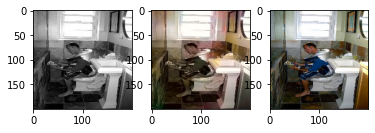

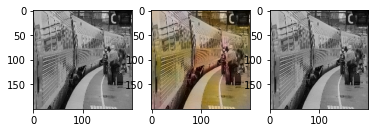

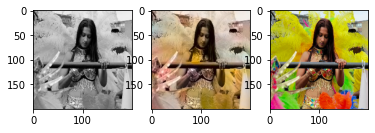

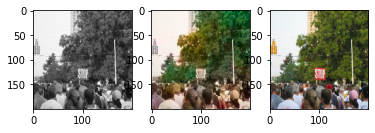

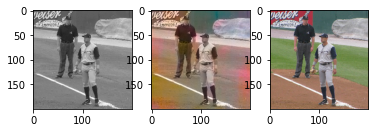

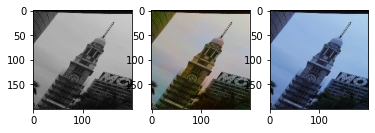

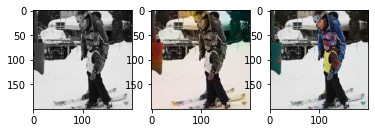

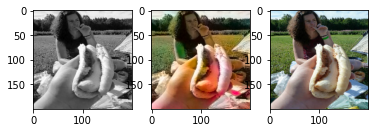

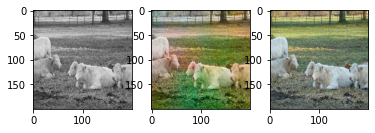

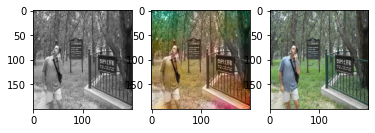

In [31]:
plt.figure()
for i in range(25, 35):
  img_black, img_predicted, img_color = get_results(i)
  f, axarr = plt.subplots(1, 3) 
  axarr[0].imshow(img_black)
  axarr[1].imshow(img_predicted)
  axarr[2].imshow(img_color)